## Models 4 : Naïve Bayes 
* ~~Logistic Regression~~
* ~~Random Forest~~
* <i><b>Naïve Bayes</b></i>
* SVM

### Model Performance Summary

This is the best model so far: train accuracy is `0.86`, and test accuracy is `0.77`, only about `0.9` diffence compared over `0.2` delta for Random Forest. 

Baseline: `0.5074`


Model   | Transformer       | Classifier            | $n$  | x-val   | Train    | Test   |  Precision    | Specificity  | Recall
---     |---                | ---                   | ---  | ---     | ---      | ---    |  ---          | ---          | ---
1*      | Count Vectorizer  | Logistic Regressor    | 2605 | 0.7373  | 0.9723   | 0.7515 | 0.7436        | 0.7179       | 0.7838 
2*      | Count Vectorizer  | Logistic Regressor    | 4537 | 0.7111  | 0.9568   | 0.7436 | 0.7527        | 0.7496       | 0.7396
3       | Count Vectorizer  | Random Forest	        | 4537 | 0.7569  | 0.9855   | 0.7154 | 0.7126        | 0.696        | 0.7325
4       | Count Vectorizer  | Naïve Bayes	        | 4537 | 0.7587  | 0.8628   | 0.7722 | 0.7682        | 0.7536       | 0.7937

In [1]:
##### BASIC IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### MODELLING IMPORTS 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

##### VECTOR MODELLING IMPORTS 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text   # TO MODIFY STOP WORDS 

from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer

In [2]:
# CUSTOM IMPORTS AND SETTINGS 
plt.style.use('gstyle.mplstyle')                        # stylesheet for sns
color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',         # colorlist, color blind pallet
                  '#f781bf', '#a65628', '#984ea3',      # from gist.github.com/thriveth/8560036
                  '#999999', '#e41a1c', '#dede00']

sns.set_palette(sns.color_palette(color_cycle))         # setting custom palette

pd.options.display.max_columns = 90                     # view settings
pd.options.display.max_rows = 100

In [3]:
# importing clean file from model 2
df = pd.read_csv('../data/reddit_2000_clean.csv')
df.shape

(4537, 2)

In [4]:
# drop all nulls
df.dropna(axis=0, inplace = True)
df.shape

(4511, 2)

### MODELING

In [6]:
# start X, y 
# NOTE: CountVectorizer requires a vector, so make sure you set X to be a pandas Series, not a DataFrame.
X = df['corpus']
y = df['class']

#### Pre-processing
Using same `stop_words` list to ensure subreddit title and closely-associated terms are not used in model. 

In [7]:
reddit_stopwords = ['porsche', 'tesla', 'taycan', 'model', 'car', 'xplaid', 'turbo']
stopwords = text.ENGLISH_STOP_WORDS.union(reddit_stopwords)

#### Naïve Bayes Classifier

In [8]:
# REMINDER: baseline
y.value_counts(normalize = True)  

1    0.507205
0    0.492795
Name: class, dtype: float64

In [9]:
# train-test split
# can use "class_weights = " if we want 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### Grid and Pipe Setup, Fit, Score

In [10]:
pipe = Pipeline([   
    ('cvec', CountVectorizer(stop_words = stopwords)),                                       
    #('tvec', TfidfVectorizer(stop_words = stopwords)),
    ('mnb', MultinomialNB())
])

In [11]:
pipe_params = {
    'cvec__max_df': [0.7, 0.8, .9, .95],
    'cvec__max_features': [3000, 4000, 5000, 7000],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [stopwords],
}

In [12]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, pipe_params, cv = 3)

In [13]:
# FIT gs 
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [14]:
#gs.best_params_

In [15]:
### all accuracy metrics 
x= ['x-val', 'NB Train', 'NB Test']
model_mets = [ 
    gs.best_score_,                 # estimate with x-val
    gs.score(X_train, y_train),     # train score 
    gs.score(X_test, y_test)      # test score 
     ]
model_mets

[0.7593886151438681, 0.8823529411764706, 0.773936170212766]

In [16]:
x= ['LR Train', 'NB Train', 'NB Test', 'LR Test']
model_mets = [0.9855, 0.8823529411764706, 0.773936170212766, 0.7154 ]

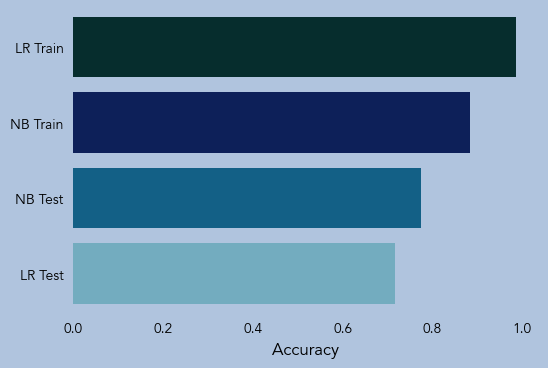

In [17]:
f, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(bottom=False, left = False)  # remove the ticks
plt.xlabel('Accuracy')

sns.despine(left=True, bottom=True)
sns.barplot(y = x, x = model_mets, palette='ocean')
plt.show()

In [18]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [19]:
# precision, specificity, recall 
class_mets = [
    round(tp/(tp + fp), 4),
    round(tn/(tn + fp), 4), 
    round(tp/(tp + fn), 4)
]
class_mets

# higher recall means more Teslas were correcctly IDed, and lower specificity shows better classification for Taycan

[0.7682, 0.7536, 0.7937]

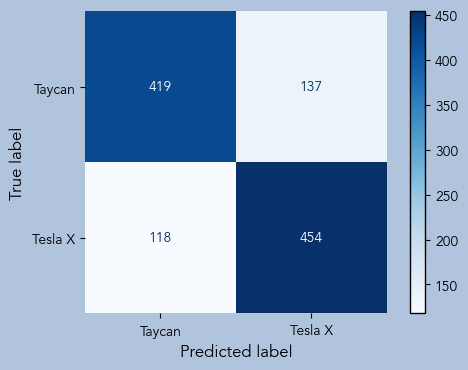

In [20]:
sub_1 = "Tesla X"
sub_2 = "Taycan"

plot_confusion_matrix(gs, X_test, y_test, cmap = 'Blues', display_labels = [sub_2, sub_1]);
(sns.despine(left=True, bottom=True))